In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pandas as pd
import keras


IMG_SIZE = (640,960,3) # Original image is 1920 x 1200 x 3, we downscale by 4 to make it manageable
BBOX_SIZE = (64, 64)
NUM_TO_SHOW = 10
LABEL_MAP = {
    "car": 1,
    "truck": 2,
    "pedestrian": 3,
    "trafficLight": 4,
    "biker": 5,
    "others": 0 # background pixels
}

df = pd.read_csv("./object-dataset/labels.csv", sep=" ")
df = df[df["label"] == "car"]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


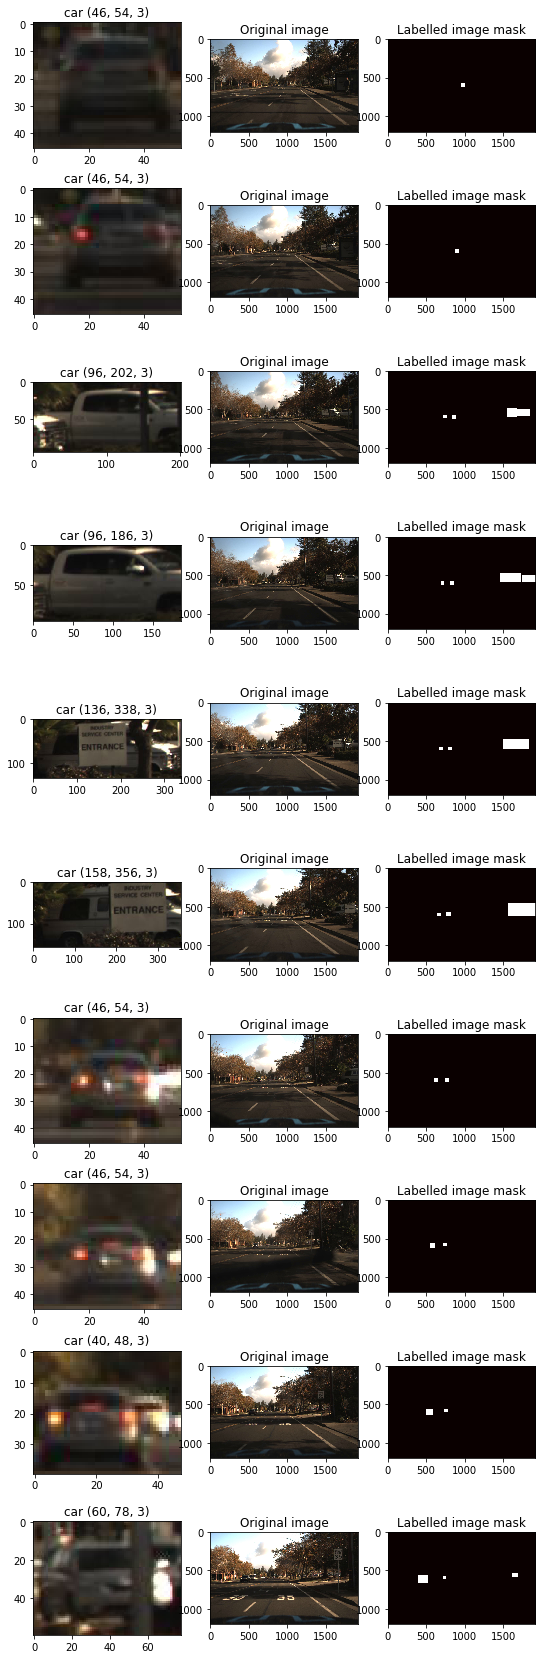

In [2]:
gb = df.groupby(df["frame"])
keys = list(gb.groups.keys())
fig, axes = plt.subplots(NUM_TO_SHOW, 3, figsize=(9, NUM_TO_SHOW * 3))
# Visualize dataset
count = 0
for index, (frame, indices) in enumerate(gb.groups.items()):
    if count < NUM_TO_SHOW:
        img = mpimg.imread("./object-dataset/" + frame)
        label = np.zeros((img.shape[0], img.shape[1]))
        for indice in indices:
            row = df.loc[indice]
            xmin = row["xmin"]
            xmax = row["xmax"]
            ymin = row["ymin"]
            ymax = row["ymax"]
            # build up dataset
            class_ = LABEL_MAP[row["label"]]
            label[ymin:ymax, xmin:xmax] = class_
            
        # Show example of 1 car
        axes[count,0].imshow(img[ymin:ymax, xmin:xmax])
        axes[count,0].set_title(row["label"] + " " + str(img[ymin:ymax, xmin:xmax].shape))
        
        # Original
        axes[count,1].imshow(img)
        axes[count,1].set_title("Original image")
        
        # Labelled
        axes[count,2].imshow(label*10, cmap='hot')
        axes[count,2].set_title("Labelled image mask")
        count += 1
    else:
        break


In [3]:
import time
from itertools import compress

FRACTION_TO_TEST = 0.8
gb = df.groupby(df["frame"])
frames = list(gb.groups.keys())
msk = np.random.rand(len(frames)) < FRACTION_TO_TEST

train = list(compress(frames, msk))
test = list(compress(frames, ~msk))

print("Splitting into train and validation sets")
print(len(test))
print(len(train))
assert(len(set(test).intersection(set(train))) == 0)

Splitting into train and validation sets
2583
10210


In [4]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, keys, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True, sample_weight = None):
        'Initialization'
        self.df = df
        self.gb = df.groupby(df["frame"])
        self.keys = keys
        self.dim = dim
        self.batch_size = batch_size
        self.dataset_size = len(self.keys)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.sample_weight = sample_weight
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.dataset_size)/ self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.dataset_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype=np.float32)
        # W = np.empty((self.batch_size, self.dim[0] * self.dim[1]))
        
        # Generate data
        for i, idx in enumerate(indices):
            frame = self.keys[idx]
            img = mpimg.imread("./object-dataset/" + frame)
            # Store sample
            X[i,] = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
            
            label = np.zeros((img.shape[0], img.shape[1]))
            rows = self.gb.groups[frame]
            
            for rowIdx in rows:
                row = self.df.loc[rowIdx]
                xmin = row["xmin"]
                xmax = row["xmax"]
                ymin = row["ymin"]
                ymax = row["ymax"]
                # Do a one-hot encoding depthwise -> if pixel(x,y) is a vehicle [x,y,0] = 0 and [x,y,1] = 1
                label[ymin:ymax, xmin:xmax] = 1.0 # vehicle layer
                # mask = np.where(label[:,:,1] != 1)
                # mask = tuple([mask[0], mask[1], np.zeros_like(mask[0])])
                # label[mask] = 1 # background layer
            
            label = cv2.resize(label, (IMG_SIZE[1], IMG_SIZE[0]))
            y[i] = np.reshape(label, (label.shape[0], label.shape[1], 1))
            # y[i] = np.reshape(np.ravel(label), (label.shape[0] * label.shape[1], 1))
            # y[i] = np.reshape(np.ravel(label), (label.shape[0]*label.shape[1],self.n_classes))
            
            # Sample weight
            # sample_weight = np.zeros_like(label)
            # sample_weight[np.where(label == 1)] = 1
            # sample_weight[np.where(label == 0)] = 0.001
            # W[i] = np.ravel(sample_weight)

        return X, y

In [5]:
# Sample weights
weights = np.zeros((IMG_SIZE[0] * IMG_SIZE[1], 2))
weights[:,0] += 0.001
weights[:,1] += 1

# Parameters
params = {'dim': (IMG_SIZE[0], IMG_SIZE[1]),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'sample_weight': weights}

validation_generator = DataGenerator(df, test, **params)
test_batch = validation_generator.__getitem__(10)
print(test_batch[0].shape, test_batch[0].dtype, test_batch[1].shape, test_batch[1].dtype)

(32, 640, 960, 3) uint8 (32, 640, 960, 1) float32


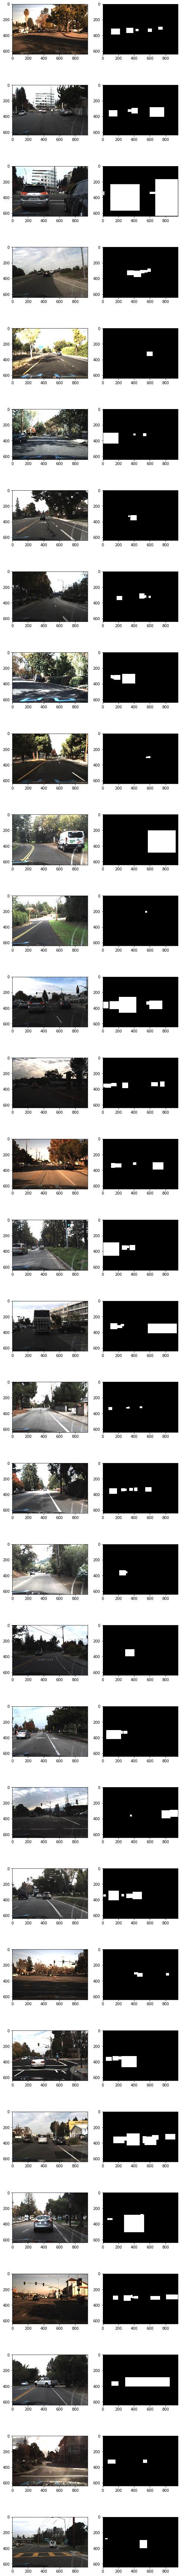

In [6]:
# test data generated by generator
fig, axes = plt.subplots(32, 2, figsize=(8, 32 * 4))
for idx in range(0, params['batch_size']):
    x_train, target = test_batch
    axes[idx,0].imshow(x_train[idx,:,:,:])
    axes[idx,1].imshow(np.reshape(target[idx,:,:,:], (target.shape[1], target.shape[2])), cmap='gray')

In [18]:
import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.models import *
from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Reshape, Lambda
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K


smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


class Unet(object):

    def __init__(self, train, test, img_rows = 512, img_cols = 512, class_weight = None, num_epochs = 1):
        self.training_generator = train
        self.validation_generator = test
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.class_weight = class_weight
        self.num_epochs = num_epochs

    def load_data(self):
        pass

    def get_unet(self):

        inputs = Input((self.img_rows, self.img_cols, 3))
        norm = Lambda(lambda x: x/127.5 - 1)(inputs)

        conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(norm)
        conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
        conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        # print("conv6 shape:",conv6.get_shape())
        
        up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
        conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
        conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
        conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
        # conv10 = Reshape((conv10.get_shape()[1] * conv10.get_shape()[2], 1))(conv10)
        
        model = Model(inputs = inputs, outputs = conv10)

        # model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, sample_weight_mode = "temporal", metrics = [dice_coef])
        model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef, 'accuracy'])
        model.summary()
        
        return model


    def train(self, force=True):
        self.model = self.get_unet()
        print("got unet")
        if force:
            model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True, save_weights_only=True)
            print('Fitting model...')
            self.model.fit_generator(generator=self.training_generator,
                            validation_data=self.validation_generator,
                            use_multiprocessing=True,
                            workers=6, epochs=self.num_epochs, verbose=1, steps_per_epoch=steps_per_epoch,
                            callbacks=[model_checkpoint])
        else:
            try:
                self.model.load_weights('unet.hdf5')
            except IOError as e:
                model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True, save_weights_only=True)
                print('Fitting model...')
                self.model.fit_generator(generator=self.training_generator,
                                validation_data=self.validation_generator,
                                use_multiprocessing=True,
                                workers=6, epochs=self.num_epochs, verbose=1, steps_per_epoch=steps_per_epoch,
                                callbacks=[model_checkpoint])
        

    def save_img(self):

        print("array to image")
        imgs = np.load('imgs_mask_test.npy')
        for i in range(imgs.shape[0]):
            img = imgs[i]
            img = array_to_img(img)
            img.save("../results/%d.jpg"%(i))


# Sample weights
weights = np.zeros((IMG_SIZE[0] * IMG_SIZE[1], 2))
weights[:,0] += 0.001
weights[:,1] += 1

# Parameters
params = {'dim': (IMG_SIZE[0], IMG_SIZE[1]),
          'batch_size': 16,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'sample_weight': weights}

num_epochs = 10
steps_per_epoch = int(len(train)//params['batch_size'])
training_generator = DataGenerator(df, train, **params)
validation_generator = DataGenerator(df, test, **params)
model = Unet(training_generator, validation_generator, IMG_SIZE[0], IMG_SIZE[1], class_weight=weights, num_epochs=num_epochs)
model.train(force=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.lay

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 640, 960, 3)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 640, 960, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 640, 960, 8)  224         lambda_7[0][0]                   
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 640, 960, 8)  584         conv2d_139[0][0]                 
__________________________________________________________________________________________________
max_poolin

Epoch 1/10
638/638 [==============================] - 413s 647ms/step - loss: 0.6356 - dice_coef: 0.3644 - acc: 0.8115 - val_loss: 0.5170 - val_dice_coef: 0.4830 - val_acc: 0.9050

Epoch 00001: loss improved from inf to 0.63561, saving model to unet.hdf5
Epoch 2/10
638/638 [==============================] - 406s 636ms/step - loss: 0.4550 - dice_coef: 0.5450 - acc: 0.9333 - val_loss: 0.3849 - val_dice_coef: 0.6151 - val_acc: 0.9553

Epoch 00002: loss improved from 0.63561 to 0.45500, saving model to unet.hdf5
Epoch 3/10
638/638 [==============================] - 407s 638ms/step - loss: 0.3839 - dice_coef: 0.6161 - acc: 0.9483 - val_loss: 0.3715 - val_dice_coef: 0.6285 - val_acc: 0.9596

Epoch 00003: loss improved from 0.45500 to 0.38391, saving model to unet.hdf5
Epoch 4/10
638/638 [==============================] - 407s 638ms/step - loss: 0.3491 - dice_coef: 0.6509 - acc: 0.9543 - val_loss: 0.3838 - val_dice_coef: 0.6162 - val_acc: 0.9609

Epoch 00004: loss improved from 0.38391 to 0.3

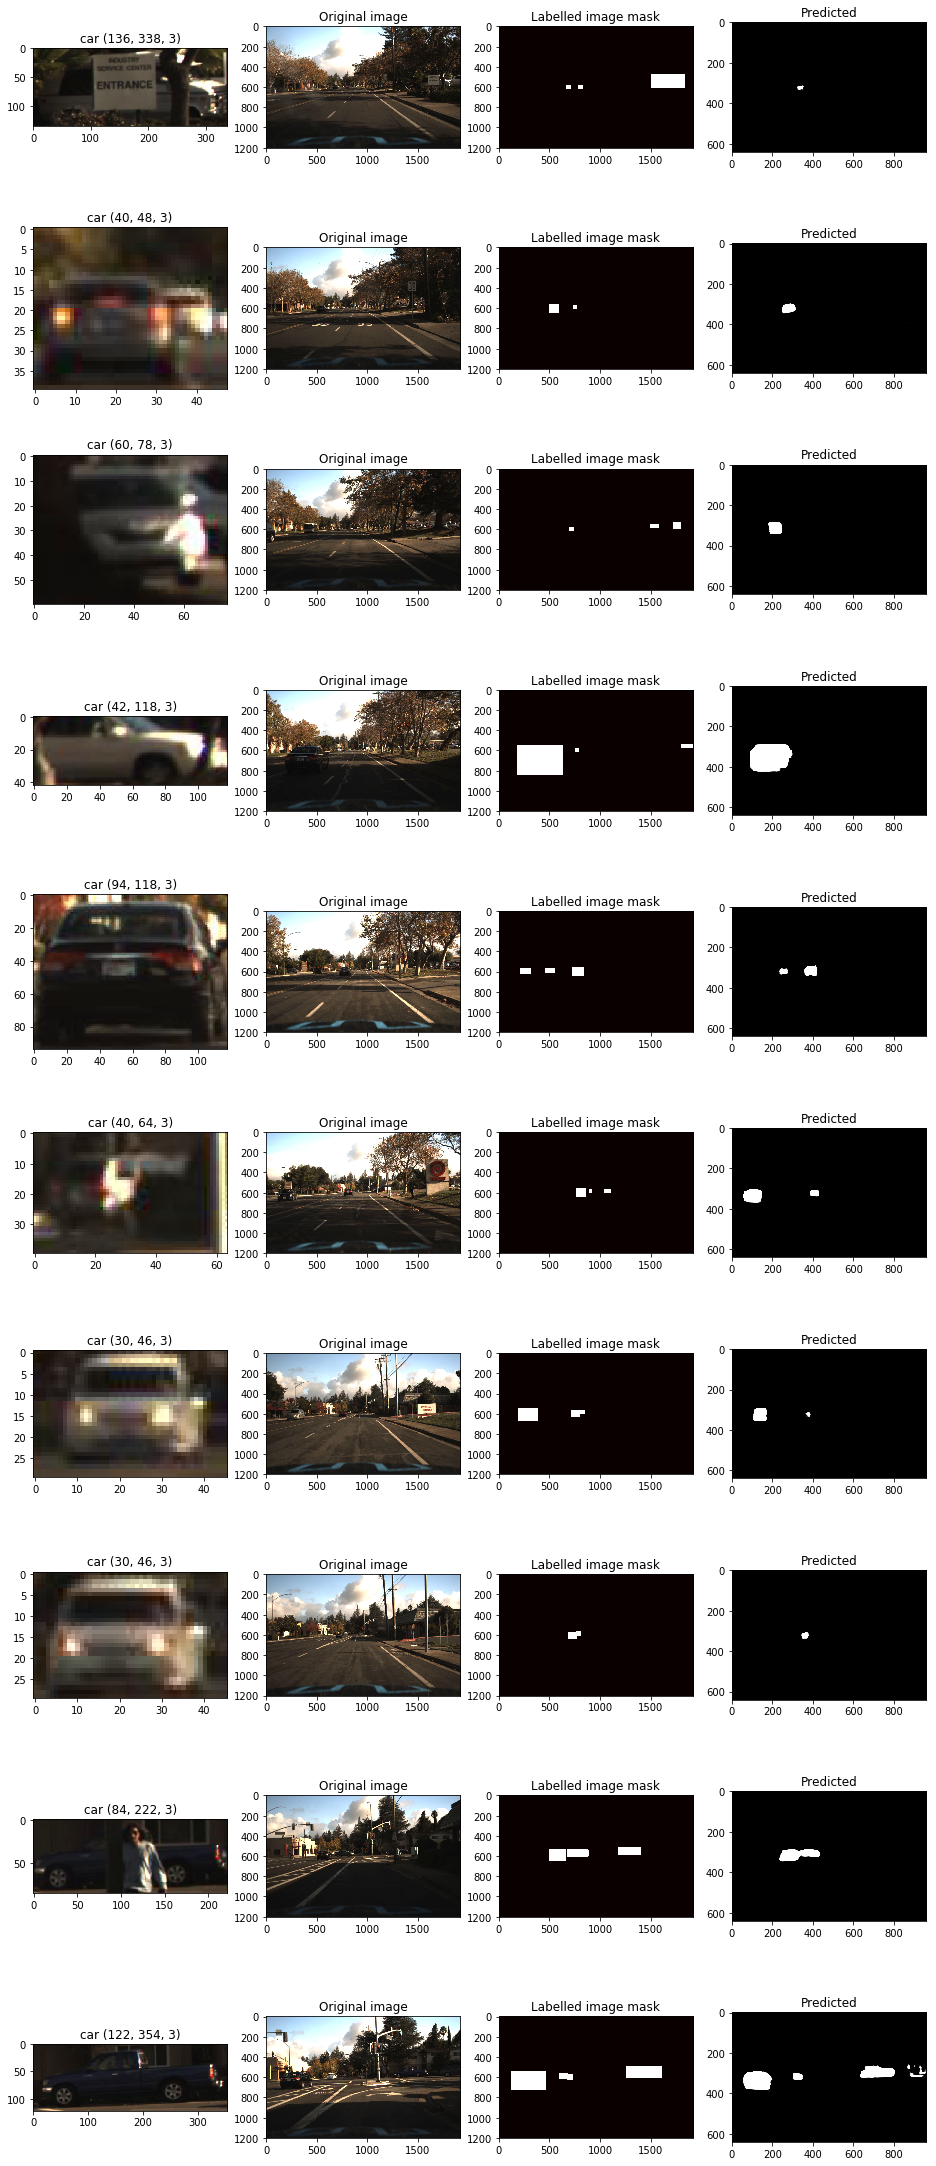

In [19]:
# Test predictions

NUM_TO_SHOW = 10
count = 0
fig, axes = plt.subplots(NUM_TO_SHOW, 4, figsize=(16, 4 * NUM_TO_SHOW))
for index, frame in enumerate(test):
    if count < NUM_TO_SHOW:
        indices = gb.groups[frame]
        img = mpimg.imread("./object-dataset/" + frame)
        label = np.zeros((img.shape[0], img.shape[1]))
        for indice in indices:
            row = df.loc[indice]
            xmin = row["xmin"]
            xmax = row["xmax"]
            ymin = row["ymin"]
            ymax = row["ymax"]
            # build up dataset
            class_ = LABEL_MAP[row["label"]]
            label[ymin:ymax, xmin:xmax] = class_
            
        # Show example of 1 car
        axes[count,0].imshow(img[ymin:ymax, xmin:xmax])
        axes[count,0].set_title(row["label"] + " " + str(img[ymin:ymax, xmin:xmax].shape))
        
        # Original
        axes[count,1].imshow(img)
        axes[count,1].set_title("Original image")
        
        # Labelled
        axes[count,2].imshow(label, cmap='hot')
        axes[count,2].set_title("Labelled image mask")
        
        img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
        img = np.reshape(img, (1, IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
        yhat = model.model.predict(img)
        yhat = np.reshape(yhat, (IMG_SIZE[0], IMG_SIZE[1]))
        
        # Predicted
        axes[count,3].imshow(yhat, cmap='gray')
        axes[count,3].set_title("Predicted")
        count += 1
    else:
        break


